In [1]:
pip install protobuf==3.20.*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import torch
import torch.nn as nn
from transformers import DistilBertModel

class SiameseEmbeddingModel(nn.Module):
    def __init__(self, projection_dim=256):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Freeze BERT for speed and stability
        for param in self.bert.parameters():
            param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(768, projection_dim),
            nn.BatchNorm1d(projection_dim),
            nn.ReLU(),
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS embedding
        proj = self.projection(cls_emb)

        # L2 normalize for cosine distance
        proj = proj / proj.norm(p=2, dim=1, keepdim=True)
        return proj


2025-12-18 17:23:07.956515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766078588.353844      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766078588.481486      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device="cuda"

In [4]:
model = SiameseEmbeddingModel().to(device)
model.load_state_dict(torch.load("/kaggle/input/simese-xss/pytorch/default/1/siamese_xss_model.pt", map_location=device))
model.eval()

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

SiameseEmbeddingModel(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): 

In [5]:
def classify_payload(model, tokenizer, centroids, payload, device="cuda"):
    model.eval()
    encoding = tokenizer(
        [payload], padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        emb = model(encoding["input_ids"], encoding["attention_mask"])
        emb = emb.cpu().numpy()[0]

    # compute nearest centroid
    best_label = None
    best_dist = 999

    for label, centroid in centroids.items():
        d = cosine_distance(emb, centroid)
        if d < best_dist:
            best_dist = d
            best_label = label

    return best_label, best_dist


In [6]:
def load_centroids(path="centroids.json"):
    import json
    with open(path, "r") as f:
        data = json.load(f)
    # convert lists back to numpy arrays
    return {label: np.array(vec) for label, vec in data.items()}

In [7]:
from numpy.linalg import norm

def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (norm(a) * norm(b))

In [8]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
centroids = load_centroids("/kaggle/input/centroids/centroids.json")



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
example_payloads = [
    'unidruck.cgi?url=""><script>alert("MaXWeL")</script>',
    'news.php?page=abc" /><script>alert(1)</script>',
    'bg_info.php?p=%27%3E%3Cscript%3Ealert%281337%29%3C/script%3E',
    'top.php?RefId=%22%3E\'%3E%3Cscript%3Ealert(%22kusomiso.com%22)%3C/script%3E',
    'cifra_lista.php?texto=""><script>alert(String.fromCharCode(88,83,83,32,98,121,32,66,117,103,66,117,115,116,101,114,32,45,32,76,101,105,97,32,98,117,103,98,117,115,116,101,114,46,99,111,109,46,98,114));</script>onde=1',
    'cautare-produse?s=%3Cscript%3Ealert(String.fromCharCode(83,105%20,108,118,121,97,110,48%20))%3C/script%3E',
    'Aboutus.asp?Title=%3Cscript%3Ealert(%22XSS%22)%3C/script%3E',
    'redvoznje.php?zadan=2009-05-22&pd=d&rv=rvm&linija[]=OSIJEK"><script>alert(document.cookie)</script>',
    'cerca.php?s_any=&s_nom="<marquee><h1><script>alert(String.fromCharCode(120,115,115,32,98,121,32,100,101,97,116,104,45,97,110,103,101,108));</script><iframe height="999" width="999" src="http://xssed.com/">&s_ambit=&s_comarca_id=&s_poble_id=&cercar=Cercar&getpdf=&any=',
    'index.html?stype=X&terms=%22%3E%3CSCRIPT%3Ealert(%27XSS_Alert%27)%3C%2FSCRIPT%3E&x=0&y=0',
    '?text=Young girl killed in Ballinasloe collision named locally %0A%0A https://galwaybayfm.ie/galway-bay-fm-news-desk/young-girl-killed-in-ballinasloe-collision-named-locally/',
    'list_news.php?ncid=N01_18_01',
    'analysis.current?nid=01&itemcode=J54D503',
    '2019/04/22/chef-democrates-repousse-idee-destitution-trump_a_23715497?ncid=other_topnaventr_coabgdcpxri&utm_campaign=topnav',
    'analysis.current?nid=01&itemcode=J54E048',
    'sharer.php?u=http%3a%2f%2ffotbal.idnes.cz%2ffotbal-online.aspx%3fonline%3d7097801%26item%3d9669572',
    'details?id=com.toi.reader.activities&utm_source=TOInewHP_TILwidget&utm_medium=ABtest&utm_campaign=TOInewHP',
    'enlarge_image.html?art_id=201904211407003&img_no=0',
    '1552944943_077789.html?autoplay=1',
    'search?query=ptk%40donga.com&check_news=1%7C2%7C3%7C4%7C5'
]


for p in example_payloads:
    label, dist = classify_payload(model, tokenizer, centroids, p)
    print(f"Payload: {p}\nPredicted: {label}, Distance: {dist:.4f}\n")

Payload: unidruck.cgi?url=""><script>alert("MaXWeL")</script>
Predicted: XSS_Ref, Distance: 0.0185

Payload: news.php?page=abc" /><script>alert(1)</script>
Predicted: XSS_Ref, Distance: 0.0237

Payload: bg_info.php?p=%27%3E%3Cscript%3Ealert%281337%29%3C/script%3E
Predicted: XSS_Ref, Distance: 0.0077

Payload: top.php?RefId=%22%3E'%3E%3Cscript%3Ealert(%22kusomiso.com%22)%3C/script%3E
Predicted: XSS_Ref, Distance: 0.0085

Payload: cifra_lista.php?texto=""><script>alert(String.fromCharCode(88,83,83,32,98,121,32,66,117,103,66,117,115,116,101,114,32,45,32,76,101,105,97,32,98,117,103,98,117,115,116,101,114,46,99,111,109,46,98,114));</script>onde=1
Predicted: XSS_Ref, Distance: 0.0321

Payload: cautare-produse?s=%3Cscript%3Ealert(String.fromCharCode(83,105%20,108,118,121,97,110,48%20))%3C/script%3E
Predicted: XSS_Ref, Distance: 0.0361

Payload: Aboutus.asp?Title=%3Cscript%3Ealert(%22XSS%22)%3C/script%3E
Predicted: XSS_Ref, Distance: 0.0133

Payload: redvoznje.php?zadan=2009-05-22&pd=d&rv=rvm&

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

# ============================================================
# 1. EMBEDDING GENERATION (FULL DATASET, BATCHED)
# ============================================================
def compute_embeddings_for_texts(
    model,
    tokenizer,
    texts,
    device="cuda",
    batch_size=64
):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                return_tensors="pt"
            ).to(device)

            emb = model(enc["input_ids"], enc["attention_mask"])
            all_embeddings.append(emb.cpu().numpy())

    embeddings = np.vstack(all_embeddings)
    print(f"✓ Generated embeddings: {embeddings.shape}")
    return embeddings


# ============================================================
# 2. SAFE LABEL HANDLING
# ============================================================
def encode_labels(labels):
    labels = np.array(labels)
    if labels.dtype.kind in {"U", "S", "O"}:
        le = LabelEncoder()
        encoded = le.fit_transform(labels)
        return encoded, le
    return labels.astype(int), None


# ============================================================
# 3. APPROXIMATE INTRA / INTER DISTANCES (MEMORY SAFE)
# ============================================================
def approximate_intra_inter_distances(
    embeddings,
    labels,
    n_pairs=100_000
):
    rng = np.random.default_rng(42)
    n = len(embeddings)

    idx_i = rng.integers(0, n, size=n_pairs)
    idx_j = rng.integers(0, n, size=n_pairs)

    same_class = labels[idx_i] == labels[idx_j]

    # cosine distance (embeddings are L2-normalized)
    distances = 1 - np.sum(
        embeddings[idx_i] * embeddings[idx_j], axis=1
    )

    intra = distances[same_class]
    inter = distances[~same_class]

    avg_intra = intra.mean() if len(intra) else None
    avg_inter = inter.mean() if len(inter) else None
    sep_ratio = avg_inter / avg_intra if avg_intra else None

    return avg_intra, avg_inter, sep_ratio


# ============================================================
# 4. CLUSTER METRICS (SAFE FOR LARGE DATASETS)
# ============================================================
def compute_cluster_metrics(
    embeddings,
    labels,
    max_sil_samples=5000
):
    labels_enc, le = encode_labels(labels)

    print("\nClustering Quality Metrics")
    print("=" * 60)

    # --- Davies–Bouldin & Calinski–Harabasz (full dataset OK) ---
    db = davies_bouldin_score(embeddings, labels_enc)
    ch = calinski_harabasz_score(embeddings, labels_enc)

    print(f"Davies-Bouldin Index: {db:.4f}  (lower is better)")
    print(f"Calinski-Harabasz Score: {ch:.2f}  (higher is better)")

    # --- Silhouette (SUBSAMPLED) ---
    if len(embeddings) > max_sil_samples:
        idx = np.random.choice(len(embeddings), max_sil_samples, replace=False)
        sil = silhouette_score(
            embeddings[idx],
            labels_enc[idx],
            metric="cosine"
        )
        print(f"Silhouette Score (subsampled): {sil:.4f}")
    else:
        sil = silhouette_score(
            embeddings,
            labels_enc,
            metric="cosine"
        )
        print(f"Silhouette Score: {sil:.4f}")

    # --- Intra / Inter distances (APPROXIMATE) ---
    avg_intra, avg_inter, sep_ratio = approximate_intra_inter_distances(
        embeddings,
        labels_enc
    )

    print("\nDistance Analysis (Approximate)")
    print("=" * 60)
    print(f"Average Intra-Category Distance: {avg_intra:.4f}")
    print(f"Average Inter-Category Distance: {avg_inter:.4f}")
    print(f"Separation Ratio (Inter/Intra): {sep_ratio:.4f}")

    return {
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch,
        "avg_intra": avg_intra,
        "avg_inter": avg_inter,
        "separation_ratio": sep_ratio,
    }


# ============================================================
# 5. t-SNE VISUALIZATION (SUBSAMPLED, KAGGLE SAFE)
# ============================================================
def plot_tsne_safe(
    embeddings,
    labels,
    label_encoder=None,
    max_points=2000,
    perplexity=30
):
    n = len(embeddings)

    if n > max_points:
        idx = np.random.choice(n, max_points, replace=False)
        embeddings = embeddings[idx]
        labels = np.array(labels)[idx]
        print(f"t-SNE using subsample: {max_points} / {n}")

    if label_encoder is not None:
        labels = label_encoder.inverse_transform(labels)

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=1000,
        random_state=42
    )

    emb_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for lab in np.unique(labels):
        mask = labels == lab
        plt.scatter(
            emb_2d[mask, 0],
            emb_2d[mask, 1],
            label=str(lab),
            s=30,
            alpha=0.7
        )

    plt.title("t-SNE Visualization of Siamese Embeddings")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [11]:
import pandas as pd

df = pd.read_csv("/kaggle/input/xss-triplet/combined_xss_data.csv")

In [12]:
"""demo_texts = df["Sentence"].tolist()
demo_labels = df["Label"].tolist()
test_embeddings = compute_embeddings_for_texts(model, tokenizer, demo_texts, device=device)
compute_cluster_metrics(test_embeddings, demo_labels, metric_for_distances="cosine")
plot_tsne(test_embeddings, demo_labels)"""

'demo_texts = df["Sentence"].tolist()\ndemo_labels = df["Label"].tolist()\ntest_embeddings = compute_embeddings_for_texts(model, tokenizer, demo_texts, device=device)\ncompute_cluster_metrics(test_embeddings, demo_labels, metric_for_distances="cosine")\nplot_tsne(test_embeddings, demo_labels)'

✓ Generated embeddings: (83884, 256)

Clustering Quality Metrics
Davies-Bouldin Index: 1.1731  (lower is better)
Calinski-Harabasz Score: 64989.69  (higher is better)
Silhouette Score (subsampled): 0.8013

Distance Analysis (Approximate)
Average Intra-Category Distance: 0.1475
Average Inter-Category Distance: 0.9649
Separation Ratio (Inter/Intra): 6.5409
t-SNE using subsample: 2000 / 83884


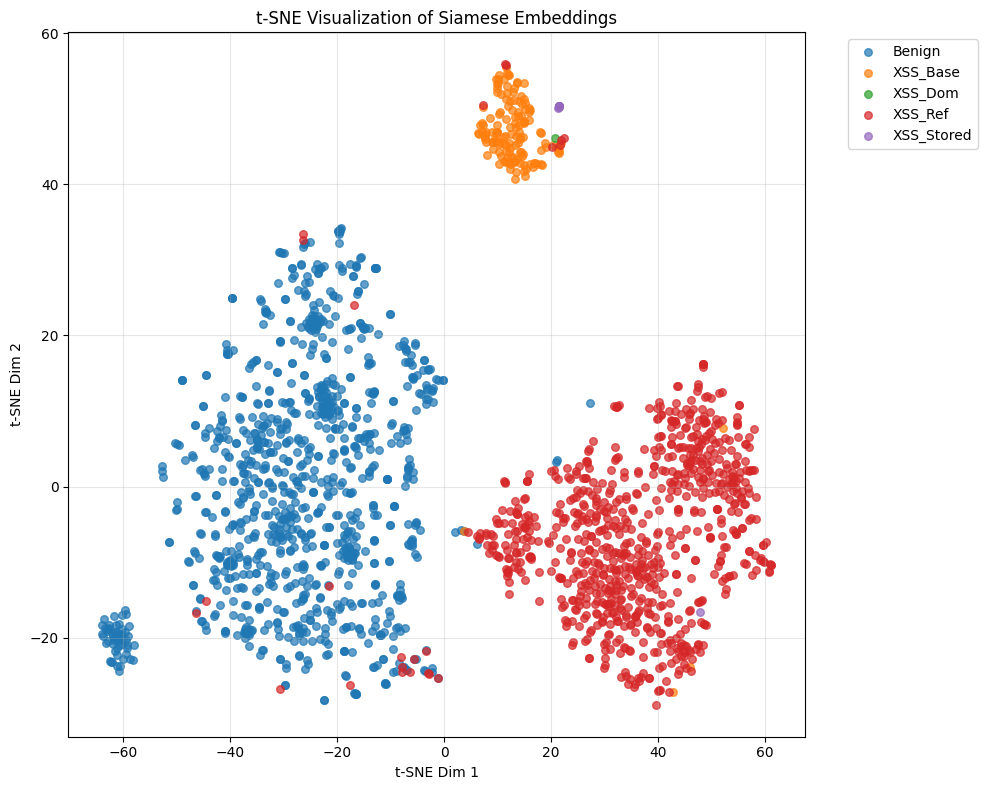

In [13]:
texts = df["Sentence"].tolist()
labels = df["Label"].tolist()

embeddings = compute_embeddings_for_texts(
 model,
 tokenizer,
 texts,
 device=device
)

metrics = compute_cluster_metrics(embeddings, labels)

labels_enc, le = encode_labels(labels)
plot_tsne_safe(
 embeddings,
 labels_enc,
 label_encoder=le
)